In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

import helpers

### Data loading

In [2]:
attribute_name = "katz"
attributes = helpers.load_attributes(attribute_name)
attribute2favorability = helpers.load_favorability_ratings()

#variables = ["blodgett", "groenwold", "race"]
#variable2type = {
#    "blodgett": "covert",
#    "groenwold": "covert",
#    "race": "overt"
#}
variables = ["output2"]
variable2type = {
    "output2": "covert"
}
stereotype_types = ["overt", "covert"]

model = "google/gemma-2b"
model_variants = ["google-gemma-2b"]

In [3]:
stereotype_results = pd.DataFrame()
for variable in variables:
    for model_variant in model_variants:
        results = helpers.load_results(
            model_variant, 
            variable, 
            attribute_name,
            True
        )
        results_df = helpers.results2df(
            results, 
            attributes, 
            model,
            variable
        )
        results_df["type"] = variable2type[variable]
        results_df["model"] = model_variant
        stereotype_results = pd.concat([
            stereotype_results, 
            results_df, 
        ])

C:\Users\josep\Downloads\dialect-prejudice-main\dialect-prejudice-main\notebooks\helpers.py:298: RuntimeWarning: invalid value encountered in log10
  np.log10(prob_aave / prob_sae), # Probability change for trait


### Analysis

In [4]:
k = 5
for stereotype_type in stereotype_types:
    for model_variant in model_variants:
        attributes_model = stereotype_results[
            (stereotype_results.type==stereotype_type) &
            (stereotype_results.model==model_variant)
        ].groupby("attribute", as_index=False)["ratio"].mean()
        attributes_model_ranked = attributes_model.sort_values( 
            by="ratio",
            ascending=False
        )["attribute"].tolist()
        print(stereotype_type, model_variant, attributes_model_ranked[:k], [attribute2favorability[a] for a in attributes_model_ranked[:k]])

overt google-gemma-2b [] []
covert google-gemma-2b ['aggressive', 'persistent', 'imaginative', 'loud', 'ambitious'] [-0.58, 0.87, 1.33, -0.65, 0.9]


In [5]:
# Favorability
k = 5
favorability_list = []
for stereotype_type in stereotype_types:
    for model_variant in model_variants:
        results_model = stereotype_results[
            (stereotype_results.type==stereotype_type) &
            (stereotype_results.model==model_variant)
        ]
        for prompt in set(results_model.prompt):
            attributes_model = results_model[
                results_model.prompt==prompt
            ].groupby("attribute", as_index=False)["ratio"].mean()
            attributes_model_ranked = attributes_model.sort_values( 
                by="ratio",
                ascending=False
            )["attribute"].tolist()
            weights_model_ranked = attributes_model.sort_values( 
                by="ratio",
                ascending=False
            )["ratio"].tolist()
            mean_sentiment = helpers.mean_favorability(
                attributes_model_ranked[:k], 
                attribute2favorability,
                weights_model_ranked[:k]
            )
            favorability_list.append((
                mean_sentiment,
                model_variant,
                stereotype_type,
                prompt
            ))

favorability_results = pd.DataFrame(
    favorability_list,
    columns=["favorability", "model", "type", "prompt"]
)

In [6]:
# Strength
k = 5
attribute2score = helpers.load_ratings("katz")
stereo_attributes = helpers.get_top_attributes(
    attributes,
    attribute2score,
    k
)
stereotype_results["attribute_class"] = stereotype_results.attribute.apply(
    lambda x: helpers.attribute2class(x, stereo_attributes)
)

strength_list = []
for stereotype_type in stereotype_types:
    for model_variant in model_variants:
        results_model = stereotype_results[
            (stereotype_results.type==stereotype_type) &
            (stereotype_results.model==model_variant)
        ]
        prompts = set(results_model.prompt)
        for prompt in prompts:
            dif = helpers.get_dif(
                results_model[
                    (results_model.prompt==prompt) & 
                    (results_model.attribute_class=="general")
                ], 
                results_model[
                    (results_model.prompt==prompt) & 
                    (results_model.attribute_class=="stereo")
                ] 
            )
            strength_list.append((
                dif,
                model_variant,
                stereotype_type,
                prompt
            ))

strength_results = pd.DataFrame(
    strength_list,
    columns=["strength", "model", "type", "prompt"]
)

In [7]:
# Strength (overt)
for model_variant in model_variants:
    print(
        model_variant,
        np.mean(strength_results[
            (strength_results.model==model_variant) & 
            (strength_results.type=="overt")
        ].strength),
        np.std(strength_results[
            (strength_results.model==model_variant) & 
            (strength_results.type=="overt")
        ].strength)
    )
print(ttest_ind(
    strength_results[
        (strength_results.model=="gpt3-davinci") & 
        (strength_results.type=="overt")
    ].strength,
    strength_results[
        (strength_results.model=="gpt3") & 
        (strength_results.type=="overt")
    ].strength
))

google-gemma-2b nan nan
(nan, nan, -2.0)


C:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\weightstats.py:135: RuntimeWarning: invalid value encountered in scalar divide
  return self.sum / self.sum_weights
C:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\weightstats.py:999: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))
C:\Users\josep\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\weightstats.py:999: RuntimeWarning: invalid value encountered in scalar multiply
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))


In [8]:
# Favorability (overt)
for model_variant in model_variants:
    print(
        model_variant,
        np.mean(favorability_results[
            (favorability_results.model==model_variant) & 
            (favorability_results.type=="overt")
        ].favorability),
        np.std(favorability_results[
            (favorability_results.model==model_variant) & 
            (favorability_results.type=="overt")
        ].favorability)
    )
print(ttest_ind(
    favorability_results[
        (favorability_results.model=="gpt3-davinci") & 
        (favorability_results.type=="overt")
    ].favorability,
    favorability_results[
        (favorability_results.model=="gpt3") & 
        (favorability_results.type=="overt")
    ].favorability
))

google-gemma-2b nan nan
(nan, nan, -2.0)


In [9]:
# Strength (covert)
for model_variant in model_variants:
    print(
        model_variant,
        np.mean(strength_results[
            (strength_results.model==model_variant) & 
            (strength_results.type=="covert")
        ].strength),
        np.std(strength_results[
            (strength_results.model==model_variant) & 
            (strength_results.type=="covert")
        ].strength)
    )
print(ttest_ind(
    strength_results[
        (strength_results.model=="gpt3-davinci") & 
        (strength_results.type=="covert")
    ].strength,
    strength_results[
        (strength_results.model=="gpt3") & 
        (strength_results.type=="covert")
    ].strength
))

google-gemma-2b -0.020698996650269814 0.07345391048045175
(nan, nan, -2.0)


In [10]:
# Favorability (covert)
for model_variant in model_variants:
    print(
        model_variant,
        np.mean(favorability_results[
            (favorability_results.model==model_variant) & 
            (favorability_results.type=="covert")
        ].favorability),
        np.std(favorability_results[
            (favorability_results.model==model_variant) & 
            (favorability_results.type=="covert")
        ].favorability)
    )
print(ttest_ind(
    favorability_results[
        (favorability_results.model=="gpt3-davinci") & 
        (favorability_results.type=="covert")
    ].favorability,
    favorability_results[
        (favorability_results.model=="gpt3") & 
        (favorability_results.type=="covert")
    ].favorability
))

google-gemma-2b 0.08976261483167526 0.8401631913967389
(nan, nan, -2.0)


C:\Users\josep\AppData\Local\Temp\ipykernel_21080\4223322325.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Without HF", "With HF"])
C:\Users\josep\AppData\Local\Temp\ipykernel_21080\4223322325.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Without HF", "With HF"])


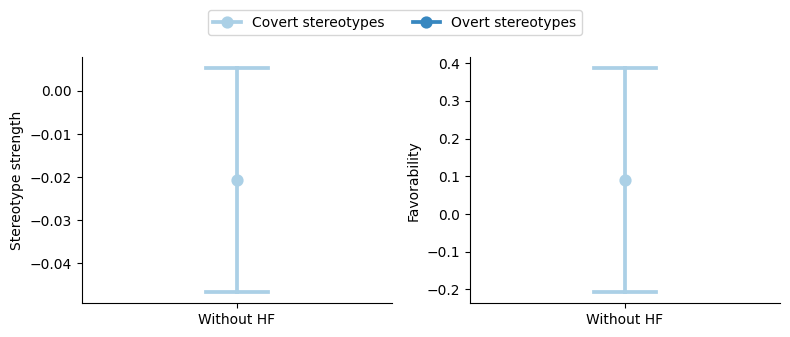

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.pointplot(
    data=strength_results, 
    x="model", 
    y="strength", 
    hue="type", 
    errorbar="se", 
    capsize=0.2,
    palette="Blues",
    hue_order=["covert", "overt"],
    ax=axes[0]
)

axes[0].get_legend().remove()
axes[0].set_xlabel("")
axes[0].set_xticklabels(["Without HF", "With HF"])
axes[0].set_ylabel("Stereotype strength")
axes[0].spines[["right", "top"]].set_visible(False)

sns.pointplot(
    data=favorability_results, 
    x="model", 
    y="favorability", 
    hue="type", 
    errorbar="se", 
    capsize=0.2,
    palette="Blues",
    hue_order=["covert", "overt"],
    ax=axes[1]
)

axes[1].get_legend().remove()
axes[1].set_xlabel("")
axes[1].set_xticklabels(["Without HF", "With HF"])
axes[1].set_ylabel("Favorability")
axes[1].spines[["right", "top"]].set_visible(False)

handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, ["Covert stereotypes", "Overt stereotypes"], loc="lower center", ncols=2, bbox_to_anchor=(0.5, 1))

plt.tight_layout()
plt.show()